In [1]:
from __future__ import print_function
from numpy import *
%pylab inline
from scipy.optimize import curve_fit
import scipy.interpolate as interpolate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# evaluates cubic bezier at t, return point
def q(ctrlPoly, t):
    return (1.0-t)**3 * ctrlPoly[0] + 3*(1.0-t)**2 * t * ctrlPoly[1] + 3*(1.0-t)* t**2 * ctrlPoly[2] + t**3 * ctrlPoly[3]


# evaluates cubic bezier first derivative at t, return point
def qprime(ctrlPoly, t):
    return 3*(1.0-t)**2 * (ctrlPoly[1]-ctrlPoly[0]) + 6*(1.0-t) * t * (ctrlPoly[2]-ctrlPoly[1]) + 3*t**2 * (ctrlPoly[3]-ctrlPoly[2])


# evaluates cubic bezier second derivative at t, return point
def qprimeprime(ctrlPoly, t):
    return 6*(1.0-t) * (ctrlPoly[2]-2*ctrlPoly[1]+ctrlPoly[0]) + 6*(t) * (ctrlPoly[3]-2*ctrlPoly[2]+ctrlPoly[1])

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
from scipy.special import comb
from numpy import *


# Fit one (or more) Bezier curves to a set of points
def fitCurve(points, maxError):
    leftTangent = normalize(points[1] - points[0])
    rightTangent = normalize(points[-2] - points[-1])
    return fitCubic(points, leftTangent, rightTangent, maxError)


def fitCubic(points, leftTangent, rightTangent, error):
    # Use heuristic if region only has two points in it
    if (len(points) == 2):
        dist = linalg.norm(points[0] - points[1]) / 3.0
        bezCurve = [points[0], points[0] + leftTangent * dist, points[1] + rightTangent * dist, points[1]]
        return [bezCurve]

    # Parameterize points, and attempt to fit curve
    u = chordLengthParameterize(points)
    bezCurve = generateBezier(points, u, leftTangent, rightTangent)
    # Find max deviation of points to fitted curve
    maxError, splitPoint = computeMaxError(points, bezCurve, u)
    if maxError < error:
        return [bezCurve]

    # If error not too large, try some reparameterization and iteration
    if maxError < error**2:
        for i in range(20):
            uPrime = reparameterize(bezCurve, points, u)
            bezCurve = generateBezier(points, uPrime, leftTangent, rightTangent)
            maxError, splitPoint = computeMaxError(points, bezCurve, uPrime)
            if maxError < error:
                return [bezCurve]
            u = uPrime

    # Fitting failed -- split at max error point and fit recursively
    beziers = []
    centerTangent = normalize(points[splitPoint-1] - points[splitPoint+1])
    beziers += fitCubic(points[:splitPoint+1], leftTangent, centerTangent, error)
    beziers += fitCubic(points[splitPoint:], -centerTangent, rightTangent, error)

    return beziers

#Algorithm Used "Ramer–Douglas–Peucker":
def generateBezier(points, parameters, leftTangent, rightTangent):
    bezCurve = [points[0], None, None, points[-1]]

    # compute the A's
    A = zeros((len(parameters), 2, 2))
    for i, u in enumerate(parameters):
        A[i][0] = leftTangent  * 3*(1-u)**2 * u
        A[i][1] = rightTangent * 3*(1-u)    * u**2

    # Create the C and X matrices
    C = zeros((2, 2))
    X = zeros(2)

    for i, (point, u) in enumerate(zip(points, parameters)):
        C[0][0] += dot(A[i][0], A[i][0])
        C[0][1] += dot(A[i][0], A[i][1])
        C[1][0] += dot(A[i][0], A[i][1])
        C[1][1] += dot(A[i][1], A[i][1])

        tmp = point - q([points[0], points[0], points[-1], points[-1]], u)

        X[0] += dot(A[i][0], tmp)
        X[1] += dot(A[i][1], tmp)

    # Compute the determinants of C and X
    det_C0_C1 = C[0][0] * C[1][1] - C[1][0] * C[0][1]
    det_C0_X  = C[0][0] * X[1] - C[1][0] * X[0]
    det_X_C1  = X[0] * C[1][1] - X[1] * C[0][1]

    # Finally, derive alpha values
    alpha_l = 0.0 if det_C0_C1 == 0 else det_X_C1 / det_C0_C1
    alpha_r = 0.0 if det_C0_C1 == 0 else det_C0_X / det_C0_C1

    # (if alpha is 0, you get coincident control points that lead to
    # divide by zero in any subsequent NewtonRaphsonRootFind() call. */
    segLength = linalg.norm(points[0] - points[-1])
    epsilon = 1.0e-6 * segLength
    if alpha_l < epsilon or alpha_r < epsilon:
        # fall back on standard (probably inaccurate) formula, and subdivide further if needed.
        bezCurve[1] = bezCurve[0] + leftTangent * (segLength / 3.0)
        bezCurve[2] = bezCurve[3] + rightTangent * (segLength / 3.0)

    else:
        # First and last control points of the Bezier curve are
        # positioned exactly at the first and last data points
        # Control points 1 and 2 are positioned an alpha distance out
        # on the tangent vectors, left and right, respectively
        bezCurve[1] = bezCurve[0] + leftTangent * alpha_l
        bezCurve[2] = bezCurve[3] + rightTangent * alpha_r

    return bezCurve

#now we update coordinates using Newton-Raphson Method.
def reparameterize(bezier, points, parameters):
    return [newtonRaphsonRootFind(bezier, point, u) for point, u in zip(points, parameters)]


#Newton Raphson Method
#Use Newton-Raphson iteration to find better root.
def newtonRaphsonRootFind(bez, point, u):
    
    d = q(bez, u)-point
    numerator = (d * qprime(bez, u)).sum()
    denominator = (qprime(bez, u)**2 + d * qprimeprime(bez, u)).sum()

    if denominator == 0.0:
        return u
    else:
        return u - numerator/denominator

#parameterize points by normalizing them in range [0,1].
def chordLengthParameterize(points):
    u = [0.0]
    for i in range(1, len(points)):
        u.append(u[i-1] + linalg.norm(points[i] - points[i-1]))

    for i, _ in enumerate(u):
        u[i] = u[i] / u[-1]

    return u


def computeMaxError(points, bez, parameters):
    maxDist = 0.0
    splitPoint = len(points)/2
    for i, (point, u) in enumerate(zip(points, parameters)):
        dist = linalg.norm(q(bez, u)-point)**2
        if dist > maxDist:
            maxDist = dist
            splitPoint = i

    return maxDist, splitPoint

#returns norm value
def normalize(v):
    return v / linalg.norm(v)
 
#bezier_curve
    """
      Given a set of control points, return the
       bezier curve defined by the control points.
       nTimes is the number of time steps, defaults to 1000
    """
def bezier_curve(points, nTimes=1000):
    

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])
    #print(xPoints)
    #print(yPoints)
    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals

#The Bernstein polynomial of n, i as a function of t
def bernstein_poly(i, n, t):
    
    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

In [3]:
def ParseFile(filepath):
    data =[]
    label=[]
    
    with open(filepath,'r',encoding="utf8") as file:
        line= file.readline()
        
        
        while line:
            #print(line)
            
            val=0
            if(not(line.startswith("// Non-ASCII") or line.startswith("WORD") or line.startswith("// ASCII") or line.startswith(" NUMSTROKES")or line.startswith("  POINTS"))):
                line=file.readline()
                continue
            if( not (line.startswith("// Non-ASCII") or line.strip().endswith(('!', '\"', '$', '%', "\'", '(', ')', ',', '-', '.',':', ';', '<', '>', '?', '@','1','A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z')))):
                val =1
            for k in range(2):    
                points=[]
                line=file.readline()
                #print(line)
                if(val==1):
                    label.append(line.strip().split(' ')[1])
                line=file.readline()
                stroke=line.strip().split(' ')[1]
                #print(stroke+"be")
                for i in range(int(stroke)):
                    #print(line)
                    line=file.readline()
                    temp=line.strip().split(' ')
                    if(val==1):
                        #print(temp[1])
                        for j in range(int(temp[1])):
                            #if(j==0):
                            #    points.append([int(temp[3+j*2]),int(temp[4+j*2]),1,0])
                            #elif(j==int(temp[1])-1):
                            #    points.append([int(temp[3+j*2]),int(temp[4+j*2]),0,1])
                           # else:
                            points.append([int(temp[3+j*2]),1920-int(temp[4+j*2]),1,1])
                            
                                
                if(val==1):
                    points[0][3]=0
                    points[len(points)-1][2]=0
                    data.append(points)      
                            
            line=file.readline()
           # print("ff "+line+" ff")   
            
        

    #print(len(data))
    #print(len(label))
    #print(len(set(label)))
    
    return data,label


In [4]:
def preprocess(np_ink):
  # Preprocessing.
  # 1. Size normalization.
  lower = np.min(np_ink[:, 0:2], axis=0)
  upper = np.max(np_ink[:, 0:2], axis=0)
  #print("low  ",lower,"upp ",upper)
  scale = upper - lower
  scale[scale == 0] = 1
  np_ink[:, 0:2] = (np_ink[:, 0:2] - lower) / scale
  np_ink[:,1]=np_ink[:,1]
  # 2. Compute deltas.
  #np_ink[1:, 0:2] -= np_ink[0:-1, 0:2]
  #np_ink = np_ink[1:, :]
  return np_ink

In [5]:
def plotpoints(xvalues,yvalues,title='plot',xlabel='x',ylabel='y'):
    plt.figure(figsize=(50,15))
    #plt.scatter(x_test[i,:,0], 1920-x_test[i,:,1])
    #print(type(x_test[i]),x_test[i][:,1])
    #plt.scatter( x_test[i][:,1], x_test[i][:,0])
    plt.plot( xvalues, yvalues)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

[-0.46048632  0.718845    0.24468082]
[-0.841637   0.9466192 -0.9003559]
[0.22703905 0.46686184 0.13528906]
[0.40846097 0.07355646 0.5939385 ]
[2.496146  1.6321038 2.066163 ]
[1.3606496 1.990251  1.1570777]
[1, 1, 0]


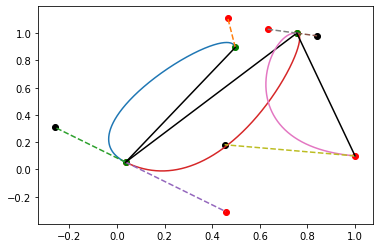

In [7]:
#Read Uji data file and Extract out the data
x_data,y_databef= ParseFile("C:\\Users\\RAJAT BHARDWAJ\\Desktop\\project\\ujipenchars2.txt")
#print( x_data, y_databef)
charlist=list(set(y_databef)) 
charlist.sort()
#time variable is used to seperate elements of text
time = 0;
chardict={}
reversechardict={}
for i in range(len(charlist)):
    chardict[i]=charlist[i]
    reversechardict[charlist[i]]=i
    
y_data=[]
for val in y_databef:
    y_data.append(reversechardict[val])

y_data=np.asarray(y_data)
dx_sentence = []
dy_sentence = []
d1_sentence = []
d2_sentence = []
alpha1_sentence = []
alpha2_sentence = []
pen_ups = []

for i in range(len(x_data)):
    #print(type(np.asarray(x_train[i])))
    if(len(x_data[i])>250):
        print(y_databef[i],len(x_data[i]))
    x_data[i]=preprocess(np.asarray(x_data[i],dtype=np.float32) )
    x_val = x_data[i][:,0]
    y_val = x_data[i][:,1]
    #plt.plot(x_val, y_val)
    #plt.show()    
    points = []
    mypoints = set([])
    for j in range(len(x_val)):
        each = []
        each.append(x_val[j])
        each.append(y_val[j])
        p = tuple(each)
        if p in mypoints:
            continue
        points.append(each)
        mypoints.add(p)
    #print(points)
    mypoints.clear()
    poin = np.array(points)
    #print(len(poin))
    bezier = []
    # We let Maxerror to be 0.25 Can be changed.
    beziers = fitCurve(poin, 0.25)
    #print(beziers)
    for bezier in beziers:
        #print(bezier)
        xPoints = np.array([p[0] for p in bezier])
        yPoints = np.array([p[1] for p in bezier])
        #print(xPoints)
        #print(yPoints)
        #xvals, yvals = bezier_curve(bezier, nTimes=1000)
        #plt.plot(xvals, yvals )
        #plt.plot(xPoints, yPoints, "ro")
        x_values = [bezier[0][0],bezier[1][0]]
        y_values = [bezier[0][1],bezier[1][1]]
        x_values1 = [bezier[3][0],bezier[2][0]]
        y_values1 = [bezier[3][1],bezier[2][1]]
        x_values2 = [bezier[3][0],bezier[0][0]]
        y_values2 = [bezier[3][1],bezier[0][1]]
        a1 = np.array([bezier[1][0],bezier[1][1]])
        b1 = np.array([bezier[2][0],bezier[2][1]])
        c1 = np.array([bezier[0][0],bezier[0][1]])
        c2 = np.array([bezier[3][0],bezier[3][1]])
        xvals, yvals = bezier_curve(bezier, nTimes=1000)

        plt.plot(xvals, yvals)
        plt.scatter(bezier[1][0], bezier[1][1],color='red')
        plt.scatter(bezier[2][0], bezier[2][1],color='black')
        plt.scatter(bezier[3][0], bezier[3][1],color='red')
        plt.scatter(bezier[0][0], bezier[0][1],color='green')
        plt.plot(x_values,y_values,'--')
        plt.plot(x_values1,y_values1,'--')
        plt.plot(x_values2,y_values2,color='black')
        #plt.show()
        dx_temp = bezier[3][0] - bezier[0][0]
        dx_sentence.append(dx_temp)
        dy_sentence += [bezier[3][1] - bezier[0][1]]
        c1_dist = sqrt((bezier[0][0] - bezier[1][0])**2 + (bezier[0][1] - bezier[1][1])**2)
        c2_dist = sqrt((bezier[3][0] - bezier[2][0])**2 + (bezier[3][1] - bezier[2][1])**2)
        chord_dist = sqrt((bezier[3][0] - bezier[0][0])**2 + (bezier[3][1] - bezier[0][1])**2)
        pen_ups += [1]

        ba = a1 - c1
        bc = c2 - c1
        cosine_angle = np.dot(ba, bc) / ((np.linalg.norm(ba) * np.linalg.norm(bc)+0.000001))
        angle1 = np.arccos(cosine_angle)

        ba = b1 - c2
        bc = c1 - c2
        cosine_angle = np.dot(ba, bc) / ((np.linalg.norm(ba) * np.linalg.norm(bc)+0.000001))
        angle2 = np.arccos(cosine_angle)

        d1_sentence += [c1_dist/chord_dist]
        d2_sentence += [c2_dist/chord_dist]
        alpha1_sentence += [angle1]
        alpha2_sentence += [angle2]
        #To Introduce Control Points, Uncomment Below two lines.
        #for nr in range(len(bezier)):
            #plt.text(bezier[nr][0], bezier[nr][1], nr)   
     #   break            
    #plt.show()        
    pen_ups[-1] = 0
    time=time+1
    if(time ==1):
        break
    
dx_sentence = np.asarray(dx_sentence, dtype=np.float32)
dy_sentence = np.asarray(dy_sentence, dtype=np.float32)
d1_sentence = np.asarray(d1_sentence, dtype=np.float32)
d2_sentence = np.asarray(d2_sentence, dtype=np.float32)
alpha1_sentence = np.asarray(alpha1_sentence, dtype=np.float32)
alpha2_sentence = np.asarray(alpha2_sentence, dtype=np.float32) 
        
                    
#plt.show()

print(dx_sentence)
print(dy_sentence)
print(d1_sentence)
print(d2_sentence)
print(alpha1_sentence)
print(alpha2_sentence)
print(pen_ups)
    
    